In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import sys

In [22]:
from matplotlib import pyplot as plt
from torchvision import utils
show_image=True
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if show_image:
        plt.show()

In [23]:
root = './data'
download = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5))])
trans = transforms.Compose([transforms.ToTensor()])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 128
kwargs = {}
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [24]:
z_size=128
hidden_size=128
img_size=28

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(hidden_size*4, hidden_size*8),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*4, img_size**2),
            nn.Tanh()
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size**2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
#             nn.Linear(hidden_size*8, hidden_size*4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
            nn.Linear(hidden_size*4, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*2, 1),
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), img_size**2))
        out = out.view(out.size(0), -1)
        return out


  0%|          | 0/10000 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



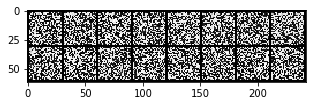

  0%|          | 6/10000 [00:02<1:21:56,  2.03it/s]


KeyboardInterrupt: 

In [30]:
from tqdm import tqdm
G = Generator()
D = Discriminator()
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
G_lr = D_lr = 5e-5
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
for epoch in tqdm(range(10000)):
    for _ in range(5):
        optimizers['D'].zero_grad()
        data=next(iter(train_loader))[0]
        if torch.cuda.is_available():
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        output_real = D(data)
        noisev = torch.randn(data.size()[0], z_size, 1, 1)
        if torch.cuda.is_available():
            noisev = Variable(noisev.cuda())
        else:
            noisev = Variable(noisev)
        fake_data = G(noisev)
        output_fake = D(fake_data)
        D_loss = -(torch.mean(output_real) - torch.mean(output_fake))

        D_loss.backward()
        optimizers['D'].step()
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

    optimizers['G'].zero_grad()
    noisev = torch.randn(data.size()[0], z_size, 1, 1)
    if torch.cuda.is_available():
        noisev = Variable(noisev.cuda())
    else:
        noisev = Variable(noisev)
    fake_data = G(noisev)
    output_fake1 = D(fake_data)
    G_loss = -torch.mean(output_fake1)

    G_loss.backward()
    optimizers['G'].step()

    if epoch % 1000 == 0:
        if torch.cuda.is_available():
            dd = utils.make_grid(fake_data.cpu().data[:16])
        else:
            dd = utils.make_grid(fake_data.data[:16])
        imshow(dd,'./results/WGAN_%d.png'%(epoch))

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        d=128
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_size, d*8, 4, 1, 0),
            nn.BatchNorm2d(d*8),
            nn.ReLU(),
            nn.ConvTranspose2d(d*8, d*4, 4, 2, 1),
            nn.BatchNorm2d(d*4),
            nn.ReLU(),
            nn.ConvTranspose2d(d*4, d*2, 4, 2, 1),
            nn.BatchNorm2d(d*2),
            nn.ReLU(),
            nn.ConvTranspose2d(d*2, d, 4, 2, 1),
            nn.BatchNorm2d(d),
            nn.ReLU(),
            nn.ConvTranspose2d(d, 1, 4, 2, 1),
            nn.Tanh(),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size, 1,1)
        out = self.model(x)
        print(out.size())
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out